<a href="https://colab.research.google.com/github/elephant2015/Code4PollutantsBiLSTM/blob/main/attention_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/datenoia1/transformed_data.csv


In [ ]:
!pip install keras-tuner --upgrade


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [ ]:
from keras_tuner import HyperModel, RandomSearch
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    """
    Construiește modelul LSTM cu hiperparametri ajustabili folosind Keras Tuner.
    """
    inputs = Input(shape=(time_steps, 1))

    # Ajustăm numărul de unități LSTM
    lstm_units = hp.Int("lstm_units", min_value=32, max_value=128, step=16)
    lstm_out = Bidirectional(LSTM(lstm_units, return_sequences=True))(inputs)

    # Ajustăm dropout
    dropout_rate = hp.Float("dropout_rate", min_value=0.1, max_value=0.5, step=0.1)
    lstm_out = Dropout(dropout_rate)(lstm_out)

    # Atenția și ieșirea finală
    attention_out = Attention()([lstm_out, lstm_out])
    dense_out = Dense(1, activation="linear")(attention_out)

    # Optimizator și rata de învățare
    learning_rate = hp.Float("learning_rate", min_value=1e-5, max_value=1e-3, sampling="log")
    optimizer = Adam(learning_rate=learning_rate)

    model = Model(inputs, dense_out)
    model.compile(optimizer=optimizer, loss="huber")
    return model


In [ ]:
from keras_tuner import RandomSearch

tuner = RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=20,  # Numărul maxim de combinații de hiperparametri testate
    executions_per_trial=2,  # Repetări pentru fiecare set de hiperparametri
    directory="tuner_results7",  # Directorul în care se salvează rezultatele
    project_name="lstm_tuning",
)


In [ ]:
X_train_residuals, y_train_residuals = create_sequences(scaled_residuals, time_steps)
X_test_residuals, y_test_residuals = create_sequences(scaled_test_residuals, time_steps)


In [ ]:
tuner.search(
    X_train_residuals,
    y_train_residuals,
    epochs=30,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor="val_loss", patience=5)],
    batch_size=64,
)


Trial 20 Complete [00h 00m 15s]
val_loss: 0.0005722023779526353

Best val_loss So Far: 0.0005713673308491707
Total elapsed time: 00h 05m 45s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best LSTM Units: {best_hps.get('lstm_units')}")
print(f"Best Dropout Rate: {best_hps.get('dropout_rate')}")
print(f"Best Learning Rate: {best_hps.get('learning_rate')}")


Best LSTM Units: 48
Best Dropout Rate: 0.5
Best Learning Rate: 0.0002987361022983302


In [ ]:
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    X_train_residuals,
    y_train_residuals,
    epochs=50,
    validation_split=0.2,
    batch_size=64,
    callbacks=[EarlyStopping(monitor="val_loss", patience=10)],
)


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0050 - val_loss: 5.7210e-04
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.2709e-04 - val_loss: 5.7980e-04
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.7086e-04 - val_loss: 5.7718e-04
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.0982e-04 - val_loss: 5.7212e-04
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.1370e-04 - val_loss: 5.7198e-04
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.3667e-04 - val_loss: 5.7206e-04
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.1865e-04 - val_loss: 5.7257e-04
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.2671e-04 - val_loss: 5.7227e-04
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.4899e-04 - val_loss: 5.7195e-04
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.6040e-04 - val_loss: 5.7264e-04
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.0759e-04 - 

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Dimensiunea scaled_test_residuals după ravel: (180,)
Dimensiunea X_test_residuals: (90, 90)
Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0163 - val_loss: 0.0022 - learning_rate: 2.9874e-04
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0032 - val_loss: 0.0023 - learning_rate: 2.9874e-04
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0031 - val_loss: 0.0022 - learning_rate: 2.9874e-04
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0031 - val_loss: 0.0022 - learning_rate: 2.9874e-04
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0032 - val_loss: 0.0022 - learning_rate: 2.9874e-04
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0031 - val_loss: 0.0022 - learning_rate: 2.9874e-04
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0031 - val_loss: 0.0022 - learning_rate: 1.4937e-04
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0030 - val_loss: 0.0022 - learning_rate: 1.4937e-04
Epoc

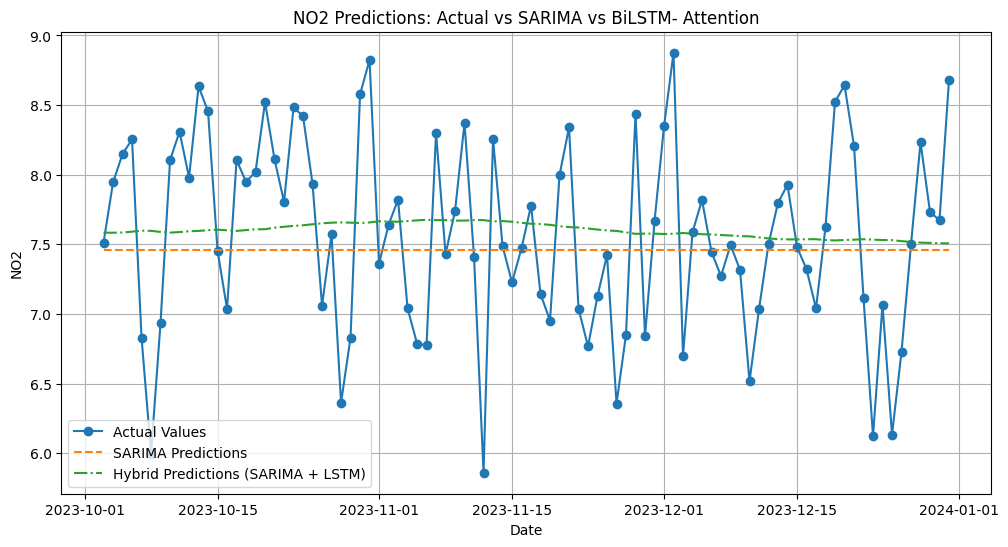

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional, Attention, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import boxcox
import tensorflow as tf

# Preprocessing data
def preprocess_data(file_path):
    data = pd.read_csv(file_path)
    data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%y')
    data = data.sort_values(by='Date')
    data.set_index('Date', inplace=True)

    # Apply Box-Cox transformation
    transformed_data = pd.DataFrame(index=data.index)
    lambda_values = {}
    for column in data.columns:
        positive_values = data[column] + abs(data[column].min()) + 1
        transformed_data[column], lambda_values[column] = boxcox(positive_values)

    return data, transformed_data, lambda_values

# Function to create sequences for LSTM
def create_sequences(data, time_steps):
    if len(data) < time_steps:
        return np.array([]), np.array([])
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

# Define LSTM model with Attention
# Define LSTM model with Attention
def build_lstm_with_attention(input_shape):
    """
    Build LSTM model with Attention mechanism.
    """
    inputs = Input(shape=input_shape)
    lstm_out = Bidirectional(LSTM(48, return_sequences=True))(inputs)
    attention_out = Attention()([lstm_out, lstm_out])  # Attention mechanism
    dense_out = Dense(1, activation='linear')(attention_out)  # Ensure single output per sequence
    model = Model(inputs, dense_out)

    optimizer = tf.keras.optimizers.AdamW(learning_rate=0.0002987361022983302, weight_decay=1e-5)
    loss = tf.keras.losses.Huber(delta=1.0)
    model.compile(optimizer=optimizer, loss=loss)
    return model


# Evaluate metrics
def evaluate_metrics(actual, forecast):
    rmse = mean_squared_error(actual, forecast, squared=False)
    mae = mean_absolute_error(actual, forecast)
    mape = np.mean(np.abs((actual - forecast) / actual)) * 100
    return rmse, mae, mape

# File path and data preparation
file_path = '../input/datenoia1/transformed_data.csv'
data, transformed_data, lambda_values = preprocess_data(file_path)

# Split into train and test sets
test_size_days = 180  # Last 6 months for test
train_data = transformed_data.iloc[:-test_size_days]
test_data = transformed_data.iloc[-test_size_days:]

# Train SARIMA and generate predictions
def train_sarima(data, order, seasonal_order):
    model = SARIMAX(data, order=order, seasonal_order=seasonal_order)
    sarima_fit = model.fit(disp=False)
    predictions = sarima_fit.fittedvalues
    return sarima_fit, predictions

# SARIMA configuration
sarima_order = (2, 1, 1)
seasonal_order = (0, 0, 0, 12)

# Train SARIMA
sarima_model, sarima_predictions_train = train_sarima(
    train_data['NO2'], sarima_order, seasonal_order
)

# Forecast SARIMA on the test set
sarima_predictions_test = sarima_model.forecast(steps=len(test_data))

# Compute SARIMA residuals
residuals = train_data['NO2'] - sarima_predictions_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_residuals = scaler.fit_transform(residuals.values.reshape(-1, 1))

# Generate sequences for LSTM
time_steps = 90

X_train_residuals, y_train_residuals = create_sequences(scaled_residuals, time_steps)

# Check if the test set contains sufficient sequences
test_residuals = test_data['NO2'] - sarima_predictions_test
scaled_test_residuals = scaler.transform(test_residuals.values.reshape(-1, 1))

# Verificăm dimensiunea scaled_test_residuals
scaled_test_residuals = scaled_test_residuals.ravel()
print(f"Dimensiunea scaled_test_residuals după ravel: {scaled_test_residuals.shape}")

X_test_residuals, _ = create_sequences(scaled_test_residuals, time_steps)
print(f"Dimensiunea X_test_residuals: {X_test_residuals.shape}")

if len(X_test_residuals) == 0:
    raise ValueError("Not enough data in the test set to create sequences for LSTM. Increase the test set size.")

# Build and train LSTM
model_lstm = build_lstm_with_attention((X_train_residuals.shape[1], 1))
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)
model_lstm.fit(
    X_train_residuals, y_train_residuals,
    validation_split=0.2,
    epochs=50, batch_size=64,
    callbacks=[early_stopping, reduce_lr]
)

# Predict residuals with LSTM
lstm_predictions = model_lstm.predict(X_test_residuals)
print(f"Dimensiunea lstm_predictions (brut): {lstm_predictions.shape}")

# Verificăm dacă dimensiunea este corectă
if len(lstm_predictions.shape) > 2:
    lstm_predictions = lstm_predictions[:, -1]  # Extragem ultima ieșire din secvență
    print(f"Dimensiunea lstm_predictions (ajustată): {lstm_predictions.shape}")

# Rescalăm predicțiile pentru a reveni la domeniul original
lstm_predictions_rescaled = scaler.inverse_transform(lstm_predictions.reshape(-1, 1))
print(f"Dimensiunea lstm_predictions_rescaled: {lstm_predictions_rescaled.shape}")


# Combine SARIMA predictions and LSTM corrections
min_length = min(len(sarima_predictions_test), len(lstm_predictions_rescaled))
sarima_predictions_aligned_trimmed = sarima_predictions_test[-min_length:]
lstm_predictions_rescaled_trimmed = lstm_predictions_rescaled.flatten()[:min_length]

# Combine predictions
final_predictions_lstm = sarima_predictions_aligned_trimmed.values + lstm_predictions_rescaled_trimmed

# Actual values for comparison
test_actual_values_trimmed = test_data['NO2'][-min_length:]

# Evaluate metrics
metrics_lstm = evaluate_metrics(test_actual_values_trimmed, final_predictions_lstm)
metrics_sarima = evaluate_metrics(test_actual_values_trimmed, sarima_predictions_aligned_trimmed)

# Print metrics
print(f"SARIMA Metrics: RMSE={metrics_sarima[0]:.3f}, MAE={metrics_sarima[1]:.3f}, MAPE={metrics_sarima[2]:.2f}%")
print(f"Hybrid (SARIMA + LSTM) Metrics: RMSE={metrics_lstm[0]:.3f}, MAE={metrics_lstm[1]:.3f}, MAPE={metrics_lstm[2]:.2f}%")

# Plot Actual vs Predictions
plt.figure(figsize=(12, 6))
plt.plot(test_actual_values_trimmed.index, test_actual_values_trimmed, label='Actual Values', marker='o', linestyle='-')
plt.plot(test_actual_values_trimmed.index, sarima_predictions_aligned_trimmed, label='SARIMA Predictions', linestyle='--')
plt.plot(test_actual_values_trimmed.index, final_predictions_lstm, label='Hybrid Predictions (SARIMA + LSTM)', linestyle='-.')
plt.title("NO2 Predictions: Actual vs SARIMA vs BiLSTM- Attention")
plt.xlabel("Date")
plt.ylabel("NO2")
plt.legend()
plt.grid(True)
plt.savefig('no2Attention.png', dpi=300, bbox_inches='tight')
plt.show()




In [ ]:
# Combine SARIMA predictions into a single DataFrame
sarima_predictions = pd.concat([
    pd.Series(sarima_predictions_train, index=train_data.index),
    pd.Series(sarima_predictions_test, index=test_data.index)
], axis=0).rename("PM25").reset_index()
sarima_predictions.columns = ['Date', 'PM25']

# Save SARIMA predictions
sarima_predictions.to_csv('sarima_predictions.csv', index=False)

# Save LSTM predictions
lstm_predictions_rescaled_df = pd.DataFrame({
    'Date': test_data.index[-len(lstm_predictions_rescaled):],
    'PM25': lstm_predictions_rescaled.flatten()
})
lstm_predictions_rescaled_df.to_csv('lstm_predictions.csv', index=False)

# Save Hybrid predictions
hybrid_predictions_df = pd.DataFrame({
    'Date': test_data.index[-len(final_predictions_lstm):],
    'PM25': final_predictions_lstm
})
hybrid_predictions_df.to_csv('hybrid_predictions.csv', index=False)


In [ ]:
time_steps = 1  # Deja utilizat, dar poate fi ajustat fin
  # Minim pentru secvențe
test_size_days = 720  # Creștem dimensiunea setului de test
train_data = transformed_data.iloc[:-test_size_days]
test_data = transformed_data.iloc[-test_size_days:]
horizons = [1, 7, 30]  # Ajustăm orizonturile

for horizon in horizons:
    print(f"\nProcessing Horizon: {horizon} day(s)")
    time_steps = max(1, horizon // 2)  # Ajustăm dimensiunea secvențelor în funcție de orizont

    # Generăm predicțiile SARIMA pentru întreg setul de test
    sarima_predictions_test = sarima_model.forecast(steps=len(test_data))
    residuals_test = test_data['PM25'] - sarima_predictions_test
    residuals_test = residuals_test.dropna()

    if len(residuals_test) < time_steps:
        print(f"Not enough residuals for Horizon {horizon}. Using SARIMA predictions only.")
        actual_values = test_data['PM25'][:len(sarima_predictions_test)]
        final_predictions = sarima_predictions_test
        rmse, mae, mape = evaluate_metrics(actual_values, final_predictions)
        print(f"Horizon: {horizon} day(s) -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, MAPE: {mape:.2f}%")
        continue

    # Generăm secvențe pentru predicția reziduurilor
    scaled_residuals_test = scaler.transform(residuals_test.values.reshape(-1, 1))
    X_test_residuals, _ = create_sequences(scaled_residuals_test.ravel(), time_steps)
    if len(X_test_residuals) == 0:
        print(f"No sequences generated for Horizon {horizon}. Skipping.")
        continue

    # Predictii cu modelul optimizat
    lstm_predictions = model_lstm.predict(X_test_residuals)

    # Reducem dimensiunea predicțiilor la ultima valoare
    lstm_predictions = lstm_predictions[:, -1]

    # Rescalăm predicțiile pentru a reveni la domeniul original
    lstm_predictions_rescaled = scaler.inverse_transform(lstm_predictions.reshape(-1, 1)).flatten()

    # Ajustăm dimensiunile pentru alinierea SARIMA și LSTM
    min_length = min(len(sarima_predictions_test), len(lstm_predictions_rescaled))
    sarima_predictions_trimmed = sarima_predictions_test[:min_length]
    lstm_predictions_trimmed = lstm_predictions_rescaled[:min_length]

    # Combinăm predicțiile SARIMA și LSTM
    final_predictions = sarima_predictions_trimmed.values + lstm_predictions_trimmed

    # Ajustăm dimensiunile pentru evaluare
    actual_values = test_data['PM25'][:min_length].values
    final_predictions = final_predictions[:min_length]

    # Calculăm metricele pentru orizontul curent
    rmse, mae, mape = evaluate_metrics(actual_values, final_predictions)
    print(f"Horizon: {horizon} day(s) -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, MAPE: {mape:.2f}%")



Processing Horizon: 1 day(s)
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Horizon: 1 day(s) -> RMSE: 0.259, MAE: 0.247, MAPE: 16.48%

Processing Horizon: 7 day(s)
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Horizon: 7 day(s) -> RMSE: 0.229, MAE: 0.215, MAPE: 14.32%

Processing Horizon: 30 day(s)
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Horizon: 30 day(s) -> RMSE: 0.141, MAE: 0.121, MAPE: 7.96%


In [ ]:
sarima_rmse, sarima_mae, sarima_mape = evaluate_metrics(test_actual_values_trimmed, sarima_predictions_aligned_trimmed)
hybrid_rmse, hybrid_mae, hybrid_mape = evaluate_metrics(test_actual_values_trimmed, final_predictions_lstm)

print(f"SARIMA Metrics: RMSE={sarima_rmse:.3f}, MAE={sarima_mae:.3f}, MAPE={sarima_mape:.2f}%")
print(f"Hybrid (SARIMA + LSTM) Metrics: RMSE={hybrid_rmse:.3f}, MAE={hybrid_mae:.3f}, MAPE={hybrid_mape:.2f}%")


SARIMA Metrics: RMSE=0.700, MAE=0.572, MAPE=7.62%
Hybrid (SARIMA + LSTM) Metrics: RMSE=0.694, MAE=0.569, MAPE=7.69%


                    Model      Mean   Std Dev  Skewness  Kurtosis  \
0                  SARIMA  0.110220  0.691212 -0.262177 -0.519044   
1  Hybrid (SARIMA + LSTM) -0.014875  0.694330 -0.259002 -0.508268   

   Durbin-Watson  Ljung-Box p-value  
0       1.327924           0.000222  
1       1.356595           0.000207  


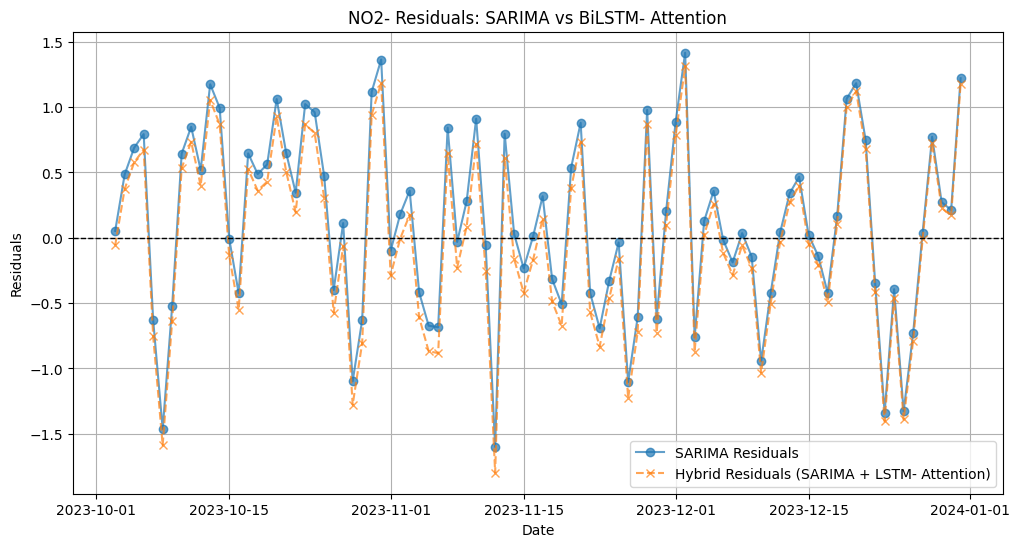

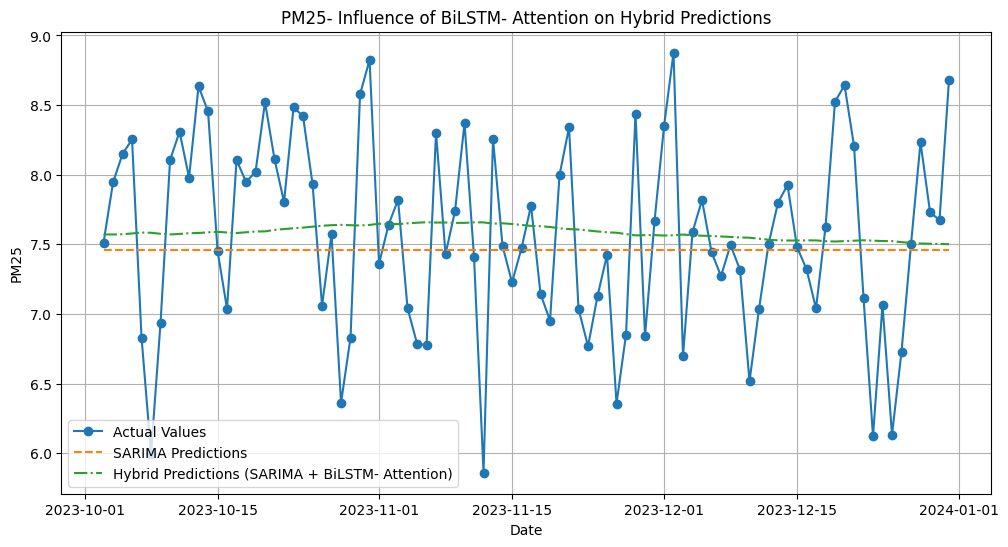

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import skew, kurtosis
from statsmodels.stats.stattools import durbin_watson

# Function to calculate residual metrics
def calculate_residual_metrics(residuals, model_name="Model"):
    if len(residuals) < 10:
        print(f"Not enough data for Ljung-Box test in {model_name}. Skipping...")
        return {
            'Model': model_name,
            'Mean': np.mean(residuals),
            'Std Dev': np.std(residuals),
            'Skewness': skew(residuals, nan_policy='omit'),
            'Kurtosis': kurtosis(residuals, nan_policy='omit'),
            'Durbin-Watson': np.nan,
            'Ljung-Box p-value': np.nan
        }

    # Calculate metrics
    mean_residual = np.mean(residuals)
    std_residual = np.std(residuals)
    skewness_residual = skew(residuals, nan_policy='omit')
    kurtosis_residual = kurtosis(residuals, nan_policy='omit')

    # Durbin-Watson statistic
    durbin_watson_stat = durbin_watson(residuals)

    # Ljung-Box test
    try:
        ljung_box_df = acorr_ljungbox(residuals, lags=[10], return_df=True)
        ljung_box_p_value = ljung_box_df['lb_pvalue'].iloc[0]
    except Exception as e:
        ljung_box_p_value = np.nan
        print(f"Error calculating Ljung-Box for {model_name}: {e}")

    metrics = {
        'Model': model_name,
        'Mean': mean_residual,
        'Std Dev': std_residual,
        'Skewness': skewness_residual,
        'Kurtosis': kurtosis_residual,
        'Durbin-Watson': durbin_watson_stat,
        'Ljung-Box p-value': ljung_box_p_value
    }
    return metrics

# Recalculăm reziduurile pentru SARIMA și modelul hibrid
residuals_sarima = test_data['NO2'][-len(sarima_predictions_aligned_trimmed):] - sarima_predictions_aligned_trimmed
residuals_hybrid = test_data['NO2'][-len(final_predictions_lstm):] - final_predictions_lstm

# Calculăm metricile folosind funcția definită
metrics_sarima_residuals = calculate_residual_metrics(residuals_sarima, model_name="SARIMA")
metrics_hybrid_residuals = calculate_residual_metrics(residuals_hybrid, model_name="Hybrid (SARIMA + LSTM)")

# Combinați metricile într-un DataFrame și afișați
residuals_metrics = pd.DataFrame([metrics_sarima_residuals, metrics_hybrid_residuals])
print(residuals_metrics)

# Salvăm metricile într-un fișier CSV
residuals_metrics.to_csv("residuals_metrics.csv", index=False)

# Plot pentru reziduurile SARIMA și Hybrid
plt.figure(figsize=(12, 6))
plt.plot(residuals_sarima, label='SARIMA Residuals', linestyle='-', marker='o', alpha=0.7)
plt.plot(residuals_hybrid, label='Hybrid Residuals (SARIMA + LSTM- Attention)', linestyle='--', marker='x', alpha=0.7)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title("NO2- Residuals: SARIMA vs BiLSTM- Attention")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.legend()
plt.grid(True)
plt.savefig('figure_namen2no2.png', dpi=300, bbox_inches='tight')
plt.show()

# Grafic pentru influența BiLSTM asupra predicțiilor hibride
plt.figure(figsize=(12, 6))
plt.plot(test_actual_values_trimmed.index, test_actual_values_trimmed, label='Actual Values', marker='o', linestyle='-')
plt.plot(test_actual_values_trimmed.index, sarima_predictions_aligned_trimmed, label='SARIMA Predictions', linestyle='--')
plt.plot(test_actual_values_trimmed.index, final_predictions_lstm, label='Hybrid Predictions (SARIMA + BiLSTM- Attention)', linestyle='-.')
plt.title("PM25- Influence of BiLSTM- Attention on Hybrid Predictions")
plt.xlabel("Date")
plt.ylabel("PM25")
plt.legend()
plt.grid(True)
plt.savefig('figure_name225.png', dpi=300, bbox_inches='tight')
plt.show()


NaN values found in Hybrid Predictions. Filling missing values with SARIMA predictions.

SARIMA Performance on Extreme Values:
  RMSE: 1.582, MAE: 1.566, MAPE: 25.08%

SARIMA + BiLSTM Performance on Extreme Values:
  RMSE: 1.644, MAE: 1.630, MAPE: 26.16%

Metrics for Extreme Values:
             Model      RMSE       MAE       MAPE
0           SARIMA  1.581700  1.565546  25.079951
1  SARIMA + BiLSTM  1.643676  1.629789  26.155748


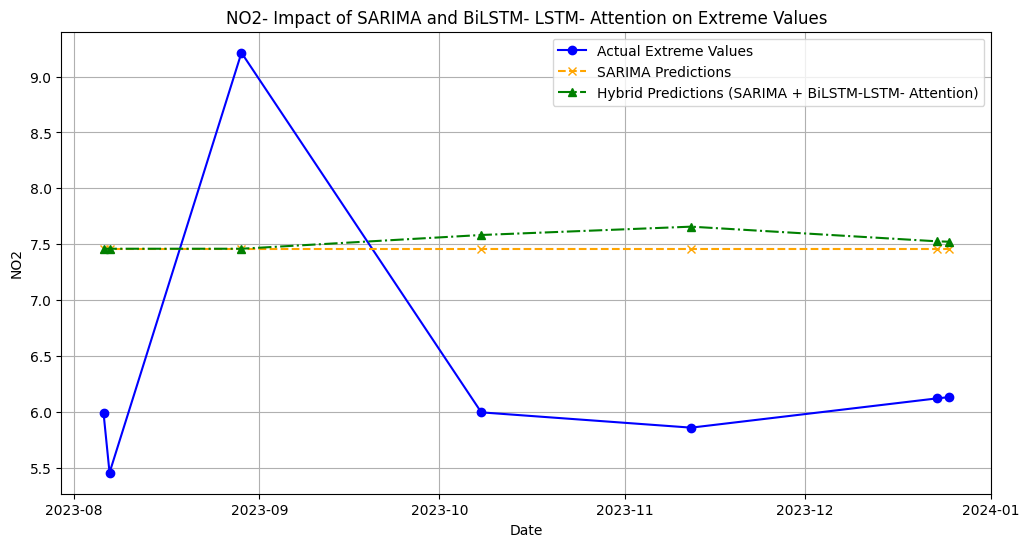

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculăm media și deviația standard
mean_pm10 = test_data['NO2'].mean()
std_pm10 = test_data['NO2'].std()

# Definim pragurile pentru valori extreme
upper_threshold = mean_pm10 + 2 * std_pm10
lower_threshold = mean_pm10 - 2 * std_pm10

# Convertim predicțiile SARIMA într-un DataFrame cu aceiași indici ca test_data['PM10']
sarima_predictions_df = pd.Series(sarima_predictions_test, index=test_data.index, name='SARIMA Predictions')

# Realiniem predicțiile hibride pentru a avea aceiași indici
hybrid_predictions_df = pd.Series(
    final_predictions_lstm,
    index=test_data.index[-len(final_predictions_lstm):],
    name='Hybrid Predictions'
).reindex(test_data.index)

# Verificăm și completăm valorile NaN în predicții
if hybrid_predictions_df.isna().any():
    print("NaN values found in Hybrid Predictions. Filling missing values with SARIMA predictions.")
    hybrid_predictions_df = hybrid_predictions_df.fillna(sarima_predictions_df)

# Identificăm valorile extreme din datele reale
extreme_actual = test_data['NO2'][(test_data['NO2'] > upper_threshold) | (test_data['NO2'] < lower_threshold)]

# Selectăm predicțiile SARIMA și hibride corespunzătoare valorilor extreme
extreme_sarima = sarima_predictions_df.loc[extreme_actual.index]
extreme_hybrid = hybrid_predictions_df.loc[extreme_actual.index]

# Verificăm și completăm valorile NaN pentru valorile extreme
if extreme_hybrid.isna().any():
    print("NaN values found in Extreme Hybrid Predictions. Filling missing values with SARIMA predictions.")
    extreme_hybrid = extreme_hybrid.fillna(extreme_sarima)

# Funcție pentru calcularea metricilor pentru valori extreme
def calculate_extreme_metrics(actual, prediction, model_name):
    rmse = mean_squared_error(actual, prediction, squared=False)
    mae = mean_absolute_error(actual, prediction)
    mape = np.mean(np.abs((actual - prediction) / actual)) * 100
    print(f"\n{model_name} Performance on Extreme Values:")
    print(f"  RMSE: {rmse:.3f}, MAE: {mae:.3f}, MAPE: {mape:.2f}%")
    return {'Model': model_name, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape}

# Calculăm metricile pentru SARIMA și Hybrid
metrics_sarima_extreme = calculate_extreme_metrics(extreme_actual, extreme_sarima, "SARIMA")
metrics_hybrid_extreme = calculate_extreme_metrics(extreme_actual, extreme_hybrid, "SARIMA + BiLSTM")

# Stocăm rezultatele într-un DataFrame
extreme_metrics = pd.DataFrame([metrics_sarima_extreme, metrics_hybrid_extreme])

# Afișăm metricile
print("\nMetrics for Extreme Values:")
print(extreme_metrics)

# Vizualizarea valorilor extreme și a predicțiilor
plt.figure(figsize=(12, 6))
plt.plot(extreme_actual.index, extreme_actual, label='Actual Extreme Values', marker='o', linestyle='-', color='blue')
plt.plot(extreme_actual.index, extreme_sarima, label='SARIMA Predictions', marker='x', linestyle='--', color='orange')
plt.plot(extreme_actual.index, extreme_hybrid, label='Hybrid Predictions (SARIMA + BiLSTM-LSTM- Attention)', marker='^', linestyle='-.', color='green')
plt.title("NO2- Impact of SARIMA and BiLSTM- LSTM- Attention on Extreme Values")
plt.xlabel("Date")
plt.ylabel("NO2")
plt.legend()
plt.grid(True)
plt.savefig('figure_nno22.png', dpi=300, bbox_inches='tight')
plt.show()
